In [15]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta 
import seaborn as sns
import re 
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import sklearn

import matplotlib.pyplot as plt

In [9]:
path = 'alldata/df_mvp.csv'
data = pd.read_csv(path)
data.dtypes

time_bin               object
label                 float64
source                 object
current_popularity    float64
wind_speed            float64
temp                  float64
status_good           float64
status_maybe          float64
status_bad            float64
dayofweek               int64
hour                    int64
dtype: object

In [10]:
# Add a column for day of the week:
data['day_name'] = pd.to_datetime(data['time_bin']).dt.day_name()
data.head()

,time_bin,label,source,current_popularity,wind_speed,temp,status_good,status_maybe,status_bad,dayofweek,hour,day_name
0,2020-03-23 14:35:00,0.0,mis/imp,42.0,26.598094,37.846753,0.0,0.0,1.0,0,14,Monday
1,2020-03-23 14:50:00,0.0,obs,42.0,25.900000,37.940000,0.0,0.0,1.0,0,14,Monday
2,2020-03-23 15:05:00,0.0,mis/imp,43.0,26.427817,38.125302,0.0,0.0,1.0,0,15,Monday
3,2020-03-23 15:20:00,0.0,mis/imp,43.0,28.181545,38.402658,0.0,0.0,1.0,0,15,Monday
4,2020-03-25 12:50:00,0.0,mis/imp,31.0,18.400000,42.080000,1.0,0.0,0.0,2,12,Wednesday


In [22]:
# One hot encoding for day of the week
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(data[['day_name']]).toarray())

#
le = LabelEncoder()
integer_encoded = le.fit_transform(data[['day_name']])
labels = le.classes_
mappings = {}
for index, label in zip(range(len(labels)), labels):
    mappings[label]=index

print("One hot encoding mapping:", mappings)

# merge with main df bridge_df on key values
df_m = data.join(enc_df)
df_m.head(1)


One hot encoding mapping: {'Friday': 0, 'Monday': 1, 'Saturday': 2, 'Sunday': 3, 'Thursday': 4, 'Tuesday': 5, 'Wednesday': 6}


/Users/isaurr/src/social_distancing/cleaning/env_sd/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,time_bin,label,source,current_popularity,wind_speed,temp,status_good,status_maybe,status_bad,dayofweek,hour,day_name,0,1,2,3,4,5,6
0,2020-03-23 14:35:00,0.0,mis/imp,42.0,26.598094,37.846753,0.0,0.0,1.0,0,14,Monday,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [65]:
## We make up some features that encode 'common sense' guesses at significant variables:


# weekend = ['Saturday', 'Sunday']
# long_weekend = ['Friday', 'Saturday', 'Sunday']
df_m['weekend'] = np.where((df_m['day_name'] == 'Saturday') | (df_m['day_name'] == 'Sunday'), 1, 0)
df_m['long_weekend'] = np.where((df_m['day_name'] == 'Saturday') | (df_m['day_name'] == 'Sunday')| (df_m['day_name'] == 'Friday'), 1, 0)


# After work, before dark (after 5/6)
df_m['aw_5'] = np.where((df_m['hour'] <= 20) & (df_m['hour']>=17), 1, 0)
df_m['aw_6'] = np.where((df_m['hour'] <= 20) & (df_m['hour']>=18), 1, 0)

# After work, before dark (after 5/6 on week DAYS)
df_m['aw_5_w'] = np.where((df_m['aw_5'] == 1) & (df_m['weekend'] == 0), 1, 0)
df_m['aw_6_w'] = np.where((df_m['aw_6'] == 1) & (df_m['weekend'] == 0), 1, 0)

df_m['afternoon'] = np.where((df_m['hour']>=12) & (df_m['hour']<=17), 1, 0)


In [66]:
df_m

,time_bin,label,source,current_popularity,wind_speed,temp,status_good,status_maybe,status_bad,dayofweek,...,4,5,6,weekend,long_weekend,aw_5,aw_6,aw_5_w,aw_6_w,afternoon
0,2020-03-23 14:35:00,0.0,mis/imp,42.0,26.598094,37.846753,0.0,0.0,1.0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
1,2020-03-23 14:50:00,0.0,obs,42.0,25.900000,37.940000,0.0,0.0,1.0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
2,2020-03-23 15:05:00,0.0,mis/imp,43.0,26.427817,38.125302,0.0,0.0,1.0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
3,2020-03-23 15:20:00,0.0,mis/imp,43.0,28.181545,38.402658,0.0,0.0,1.0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
4,2020-03-25 12:50:00,0.0,mis/imp,31.0,18.400000,42.080000,1.0,0.0,0.0,2,...,0.0,0.0,1.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,2020-04-25 17:35:00,1.0,mis/imp,117.0,3.600000,58.783333,1.0,0.0,0.0,5,...,0.0,0.0,0.0,1,1,1,0,0,0,1
510,2020-04-26 14:35:00,0.0,mis/imp,18.0,9.800000,47.473333,0.0,1.0,0.0,6,...,0.0,0.0,0.0,1,1,0,0,0,0,1
511,2020-04-26 14:50:00,0.0,obs,19.0,9.800000,47.466667,0.0,1.0,0.0,6,...,0.0,0.0,0.0,1,1,0,0,0,0,1
512,2020-04-26 15:05:00,0.0,mis/imp,14.0,9.800000,47.433333,0.0,1.0,0.0,6,...,0.0,0.0,0.0,1,1,0,0,0,0,1


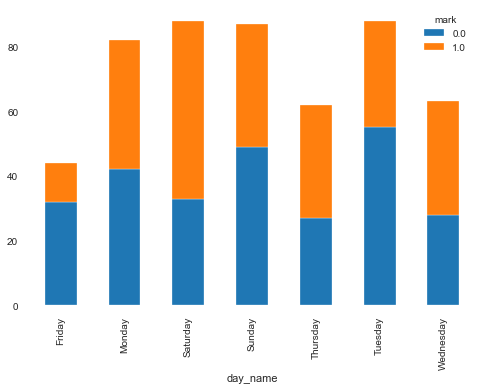

In [72]:
t1 = pd.crosstab(index=df_m["day_name"], columns=df_m["label"])

t1.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

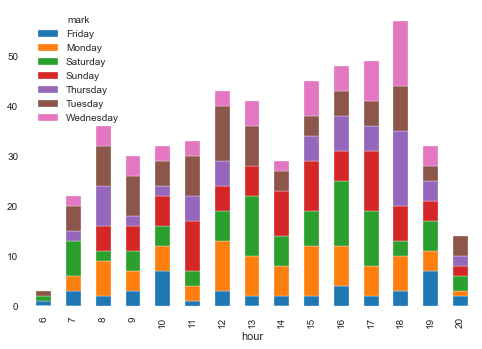

In [69]:
t2 = pd.crosstab(index=df_m["hour"], columns=df_m["day_name"])

t2.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

In [70]:
t3 = pd.crosstab(index=df_m["label"], columns=df_m["hour"])
t3

hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
label,,,,,,,,,,,,,,,
0.0,3,15,24,24,21,21,22,13,10,21,18,22,20,19,13
1.0,0,7,12,6,11,12,21,28,19,24,30,27,37,13,1


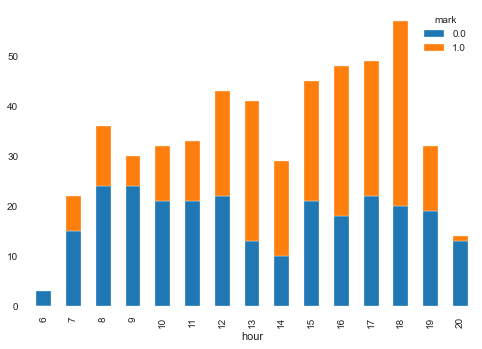

In [71]:
t4 = pd.crosstab(index=df_m["hour"], columns=df_m["label"])

t4.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

In [158]:
df_m.columns

Index([          'time_bin',              'label',             'source',
       'current_popularity',         'wind_speed',               'temp',
              'status_good',       'status_maybe',         'status_bad',
                'dayofweek',               'hour',           'day_name',
                          0,                    1,                    2,
                          3,                    4,                    5,
                          6,            'weekend',       'long_weekend',
                     'aw_5',               'aw_6',             'aw_5_w',
                   'aw_6_w',          'afternoon'],
      dtype='object')

label       0.0  1.0
status_bad          
0.0         214  207
1.0          52   41


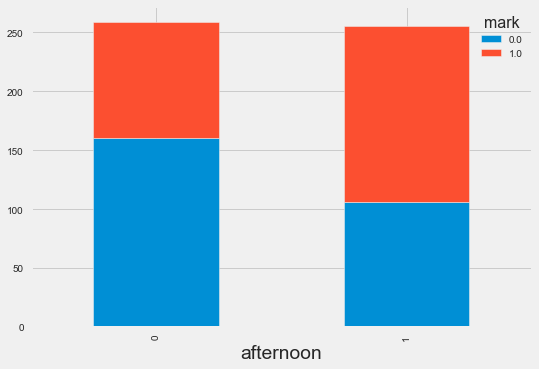

In [173]:
# Checking balance, new variables:

t_status_bad = pd.crosstab(index=df_m["status_bad"], columns=df_m["label"])

print(t_status_bad)
t_afternoon.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

label         0.0  1.0
status_maybe          
0.0           152  177
1.0           114   71


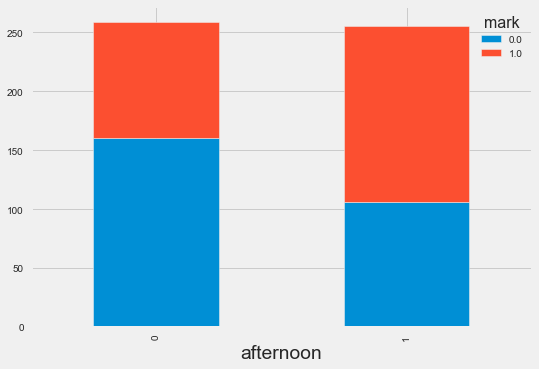

In [172]:
# Checking balance, new variables:

t_status_maybe = pd.crosstab(index=df_m["status_maybe"], columns=df_m["label"])

print(t_status_maybe)
t_afternoon.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

label        0.0  1.0
status_good          
0.0          166  112
1.0          100  136


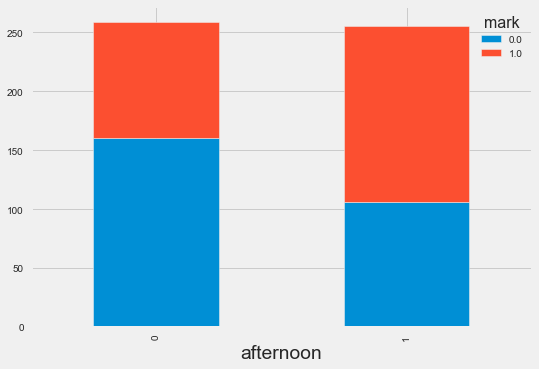

In [171]:
# Checking balance, new variables:

t_status_good = pd.crosstab(index=df_m["status_good"], columns=df_m["label"])

print(t_status_good)
t_afternoon.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

label      0.0  1.0
afternoon          
0          160   99
1          106  149


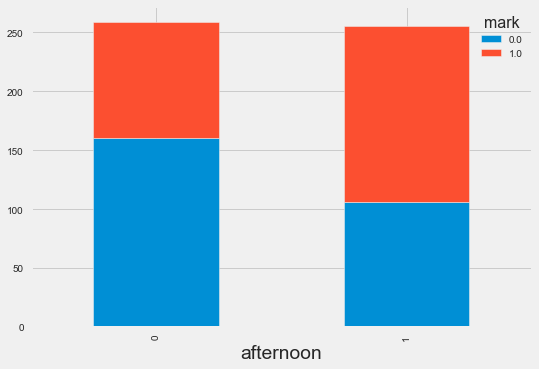

In [170]:
# Checking balance, new variables:

t_afternoon = pd.crosstab(index=df_m["afternoon"], columns=df_m["label"])

print(t_afternoon)
t_afternoon.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

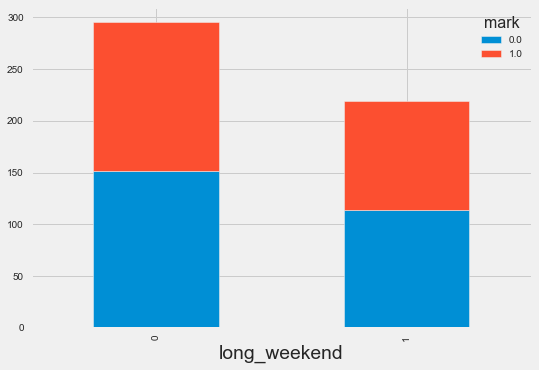

In [168]:
# Checking balance, new variables:

t_long_weekend = pd.crosstab(index=df_m["long_weekend"], columns=df_m["label"])

t_long_weekend.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

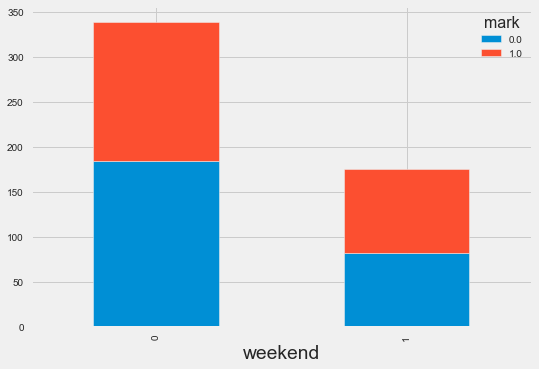

In [166]:
# Checking balance, new variables:

t_weekend = pd.crosstab(index=df_m["weekend"], columns=df_m["label"])

t_weekend.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

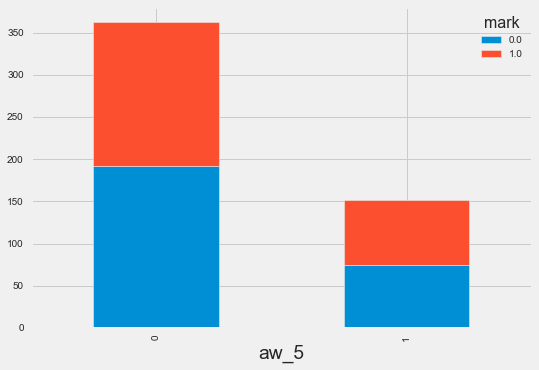

In [163]:
# Checking balance, new variables:

t_aw_5 = pd.crosstab(index=df_m["aw_5"], columns=df_m["label"])

t_aw_5.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

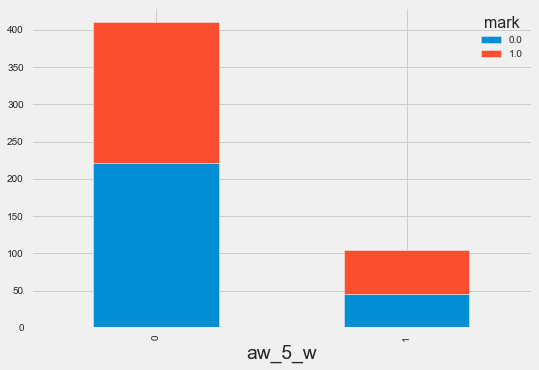

In [162]:
# Checking balance, new variables:

t_aw_5_w = pd.crosstab(index=df_m["aw_5_w"], columns=df_m["label"])

t_aw_5_w.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

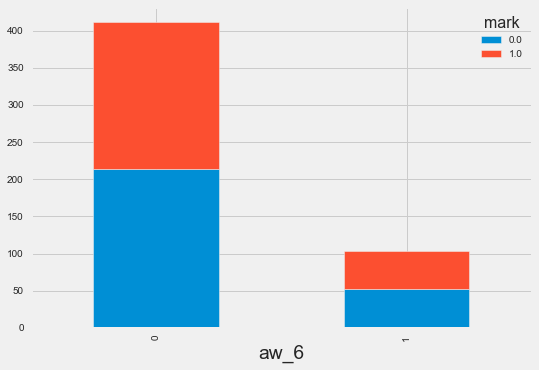

In [164]:
# Checking balance, new variables:

t_aw_6 = pd.crosstab(index=df_m["aw_6"], columns=df_m["label"])

t_aw_6.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

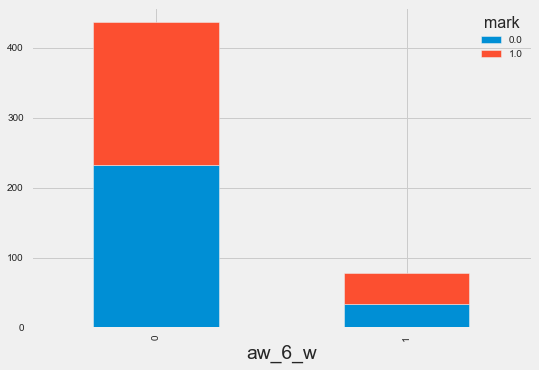

In [165]:
# Checking balance, new variables:

t_aw_6_w = pd.crosstab(index=df_m["aw_6_w"], columns=df_m["label"])

t_aw_6_w.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

# Fitting some models

In [ ]:
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [79]:
df_m.columns

Index([          'time_bin',              'label',             'source',
       'current_popularity',         'wind_speed',               'temp',
              'status_good',       'status_maybe',         'status_bad',
                'dayofweek',               'hour',           'day_name',
                          0,                    1,                    2,
                          3,                    4,                    5,
                          6,            'weekend',       'long_weekend',
                     'aw_5',               'aw_6',             'aw_5_w',
                   'aw_6_w',          'afternoon'],
      dtype='object')

In [125]:
df_m1 = df_m[['current_popularity',         'wind_speed',               'temp',
              'status_good',       'status_maybe',         'status_bad',
                'dayofweek',               'hour',           'label',
                          0,                    1,                    2,
                          3,                    4,                    5,
                          6,            'weekend',       'long_weekend',
                     'aw_5',               'aw_6',             'aw_5_w',
                   'aw_6_w',          'afternoon']]

x = df_m1.drop('label',axis = 1)
y = df_m1['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=4)


from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1, penalty='l1', solver='liblinear')

clf.fit(x_train, y_train)


thetaLasso=clf.coef_

print("The regularized theta using lasso regression:\n")
thetas = []
for i in range(len(x.columns)):
    thetas.append([x.columns[i],thetaLasso[0][i]] )
for i in range(len(thetas)):
    print(thetas[i])

y_pred = clf.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_percentage = 100 * accuracy

print("accuracy:", accuracy_percentage)
print("\nClassificationReport")
print(classification_report(y_test, y_pred))

The regularized theta using lasso regression:

['current_popularity', 0.013890044543653108]
['wind_speed', -0.019886966892317594]
['temp', 0.04525894934572184]
['status_good', 0.0]
['status_maybe', -0.10766015040952]
['status_bad', -0.0033076091148626164]
['dayofweek', -0.05600251191943116]
['hour', -0.18315605821961867]
[0, -0.28720032129149914]
[1, -0.2734611585096941]
[2, 0.4113349783546118]
[3, -0.1285358449093044]
[4, 0.4057865582200376]
[5, -0.6697351442300993]
[6, 0.0]
['weekend', 0.0]
['long_weekend', -1.638276839118523e-06]
['aw_5', 0.0]
['aw_6', 0.6378695524040305]
['aw_5_w', 1.1840821801620753]
['aw_6_w', 0.09695882981703689]
['afternoon', 1.043140346564126]
accuracy: 68.9922480620155

ClassificationReport
              precision    recall  f1-score   support

         0.0       0.75      0.69      0.72        74
         1.0       0.62      0.69      0.66        55

    accuracy                           0.69       129
   macro avg       0.69      0.69      0.69       129
w

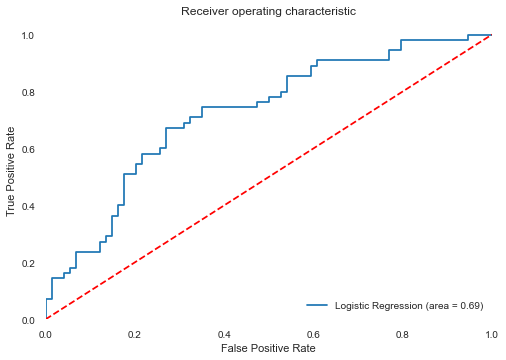

In [84]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, clf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Trying again without days of the week:

In [134]:
for element in thetas:
    if element[1] == 0:
        del(element)
print(thetas)

[['current_popularity', 0.01592170126486202], ['wind_speed', -0.015874713812054377], ['temp', 0.02688118677740817], ['status_good', 0.0], ['status_maybe', -0.22772787432735775], ['status_bad', 0.0], ['dayofweek', 0.08250473690212037], ['hour', -0.17651941350900646], ['weekend', 0.1470748071007696], ['long_weekend', -0.40562557755321044], ['aw_5', 0.0], ['aw_6', 0.6884075104454028], ['aw_5_w', 1.1953879089407022], ['aw_6_w', 0.08147927127380805], ['afternoon', 1.0532803327555962]]


In [147]:
df_m1 = df_m[['current_popularity', 'temp', 'status_maybe',  'hour', 
              'label','weekend','aw_6', 'aw_5_w','aw_6_w','afternoon']]

x = df_m1.drop('label',axis = 1)
y = df_m1['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=4)


from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1, penalty='l1', solver='liblinear')

clf.fit(x_train, y_train)


thetaLasso=clf.coef_

print("The regularized theta using lasso regression:\n")
thetas = []
for i in range(len(x.columns)):
    thetas.append([x.columns[i],thetaLasso[0][i]] )
for i in range(len(thetas)):
    print(thetas[i])

y_pred = clf.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_percentage = 100 * accuracy

print("accuracy:", accuracy_percentage)
print("\nClassificationReport")
print(classification_report(y_test, y_pred))

The regularized theta using lasso regression:

['current_popularity', 0.01563467507394655]
['temp', 0.035036254557001614]
['status_maybe', -0.2111255992778279]
['hour', -0.17918588217075182]
['weekend', 0.18469792900545787]
['aw_6', 0.6811517230526998]
['aw_5_w', 1.228979544658271]
['aw_6_w', 0.035968561475710495]
['afternoon', 1.0118712116746207]
accuracy: 66.66666666666666

ClassificationReport
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.71        74
         1.0       0.61      0.60      0.61        55

    accuracy                           0.67       129
   macro avg       0.66      0.66      0.66       129
weighted avg       0.67      0.67      0.67       129



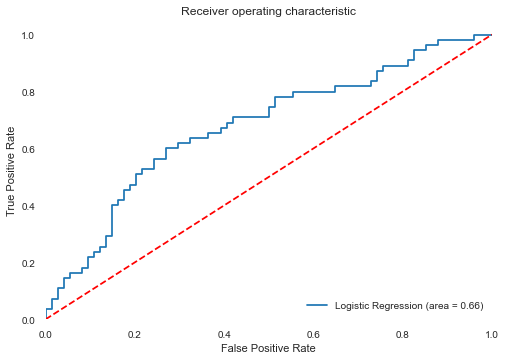

In [148]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, clf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Random Forest Model

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


Average number of nodes 180
Average maximum depth 14


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Recall Baseline: 1.0 Test: 0.81 Train: 1.0
Precision Baseline: 0.48 Test: 0.8 Train: 1.0
Roc Baseline: 0.5 Test: 0.9 Train: 1.0


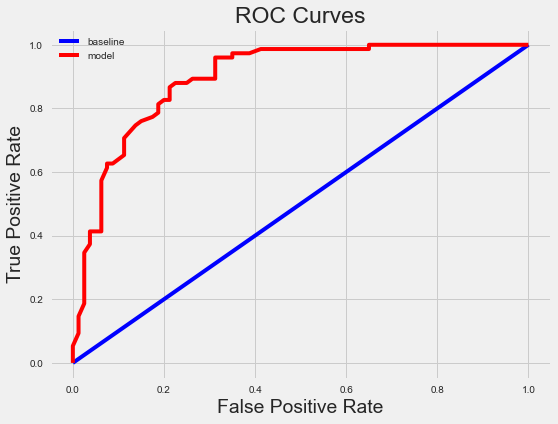

Confusion matrix, without normalization
[[65 15]
 [14 61]]


<Figure size 576x396 with 0 Axes>

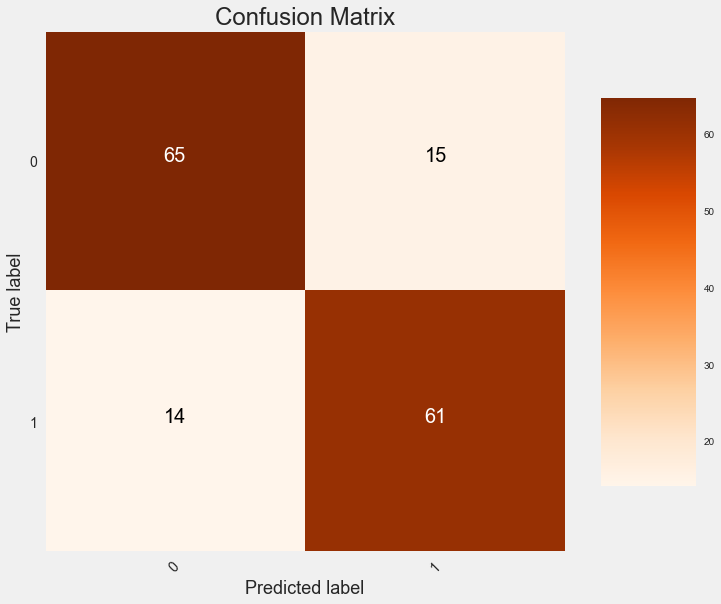

In [157]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

RSEED = 50
df_m1 = df_m[['current_popularity',         'wind_speed',               'temp',
                     'status_maybe',         'status_bad',
                'dayofweek',               'hour',           'label',
                          0,                    1,                    2,
                          3,                    4,                    5,
                          6,            'weekend',       'long_weekend',
                     'aw_5',               'aw_6',             'aw_5_w',
                   'aw_6_w',          'afternoon']]



RSEED = 50

# Load in data
df = df_m1

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.3, 
                                         random_state = RSEED)

# Imputation of missing values
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)


n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
plt.savefig('roc_auc_curve.png')

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

plt.savefig('cm.png')